<a href="https://colab.research.google.com/github/luanakwon/GreatBarrierReef/blob/main/GBR_YOLOBasic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from kaggle api
kaggle  
https://www.kaggle.com/c/tensorflow-great-barrier-reef/data  

kaggle API usage  
https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

In [1]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=2fa639d7be450ab549d8e044cf369ec54d1fe218adea98e1372db66ec0e1330b
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [3]:
!kaggle competitions download -c tensorflow-great-barrier-reef

100% 14.2G/14.2G [03:49<00:00, 49.3MB/s]
100% 14.2G/14.2G [03:49<00:00, 66.4MB/s]


In [4]:
!unzip -q /content/tensorflow-great-barrier-reef.zip 

# Session 1
---
Useful links  
- [YOLOv5 - Train Custom Data github](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)  


In [5]:
# create hierarchy
import os

for f1 in 'train', 'val', 'test':
  for f2 in 'images', 'labels':
    os.makedirs(f'/content/Datasets/{f1}/{f2}')

In [6]:
# get train.csv
import pandas as pd

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]
...,...,...,...,...,...,...
23496,2,29859,10755,2983,2-10755,[]
23497,2,29859,10756,2984,2-10756,[]
23498,2,29859,10757,2985,2-10757,[]
23499,2,29859,10758,2986,2-10758,[]


In [7]:
def annotation2YoloFormat(_annotation, width=1280, height=720):
  out = ''
  if isinstance(_annotation,str):
    a = _annotation
    while True:
      ix = a.find("'x': ")
      iy = a.find("'y': ")
      iw = a.find("'width': ")
      ih = a.find("'height': ")
      
      if ix < 0 or iy < 0 or iw < 0 or ih < 0:
        break

      x = float(a[ix + len("'x': "):a.find(", 'y")])/width
      y = float(a[iy + len("'y': "):a.find(", 'w")])/height
      w = float(a[iw + len("'width': "):a.find(", 'h")])/width
      h = float(a[ih + len("'height': "):a.find('}')])/height
      
      
      out += '0 %.6f %.6f %.6f %.6f\n'%(x+w/2, y+h/2, w, h)
      a = a[a.find('}')+1:]
    
    out = out[:-1]
  return out

In [8]:
# read images from /content/train_images
# change name
# save the image to train | val | test. ratio = 0.64 : 0.16 : 0.2
# create corresponding txt file and save

# change image name to image id
# split images by train:val:test = .64:.16:.2
import shutil
import os
import random

%cd train_images

TEST_DIRECTORY = "../Datasets/test"
TRAIN_DIRECTORY = "../Datasets/train"
VAL_DIRECTORY = "../Datasets/val"

for dir in os.listdir():
  # print(dir)
  for image in os.listdir(dir):
    random_key = random.random()
    if random_key < 0.64:
      random_folder = TRAIN_DIRECTORY
    elif random_key < 0.8:
      random_folder = VAL_DIRECTORY
    else:
      random_folder = TEST_DIRECTORY
    shutil.move(f'{dir}/{image}', f"../Datasets/{random_folder}/images/{dir[-1]}-{image}")

    # might add label as well while in iteration
    # as YOLO format [{xywh},{},...]
    f = open(f"../Datasets/{random_folder}/labels/{dir[-1]}-{image[:-4]}.txt", 'w')
    f.write(annotation2YoloFormat(df_train.loc[df_train['image_id']==f'{dir[-1]}-{image[:-4]}', 'annotations'].iloc[0]))
    f.close()

%cd ..
!rm -rf train_images/

/content/train_images
/content


In [9]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 70.7/166.8 GB disk)


# Under /content/yolov5

In [10]:
# create yaml file and save to /data (your at /content/yolov5)
# https://drive.google.com/file/d/12OIC7URFIcexi5sIEn1SzReG-TaNfJfh/view?usp=sharing
!gdown --id 12OIC7URFIcexi5sIEn1SzReG-TaNfJfh -O ./data/GBR.yaml

Downloading...
From: https://drive.google.com/uc?id=12OIC7URFIcexi5sIEn1SzReG-TaNfJfh
To: /content/yolov5/data/GBR.yaml
100% 427/427 [00:00<00:00, 598kB/s]


In [13]:
# Train YOLOv5s on COCO128 for 3 epochs
# --img : image size (size,size)
# --batch : batch size
# --epochs : epochs
# --data : .yaml file name
# --weights : pretrained weights ('' --cfg yolov5s.yaml if from scratch)
!python train.py --img 640 --batch 16 --epochs 3 --data GBR.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=GBR.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, sca

# Visualization

In [15]:
# visualize
from utils.plots import plot_results 
plot_results('./runs/train/exp2/results.csv')  # plot 'results.csv' as 'results.png'

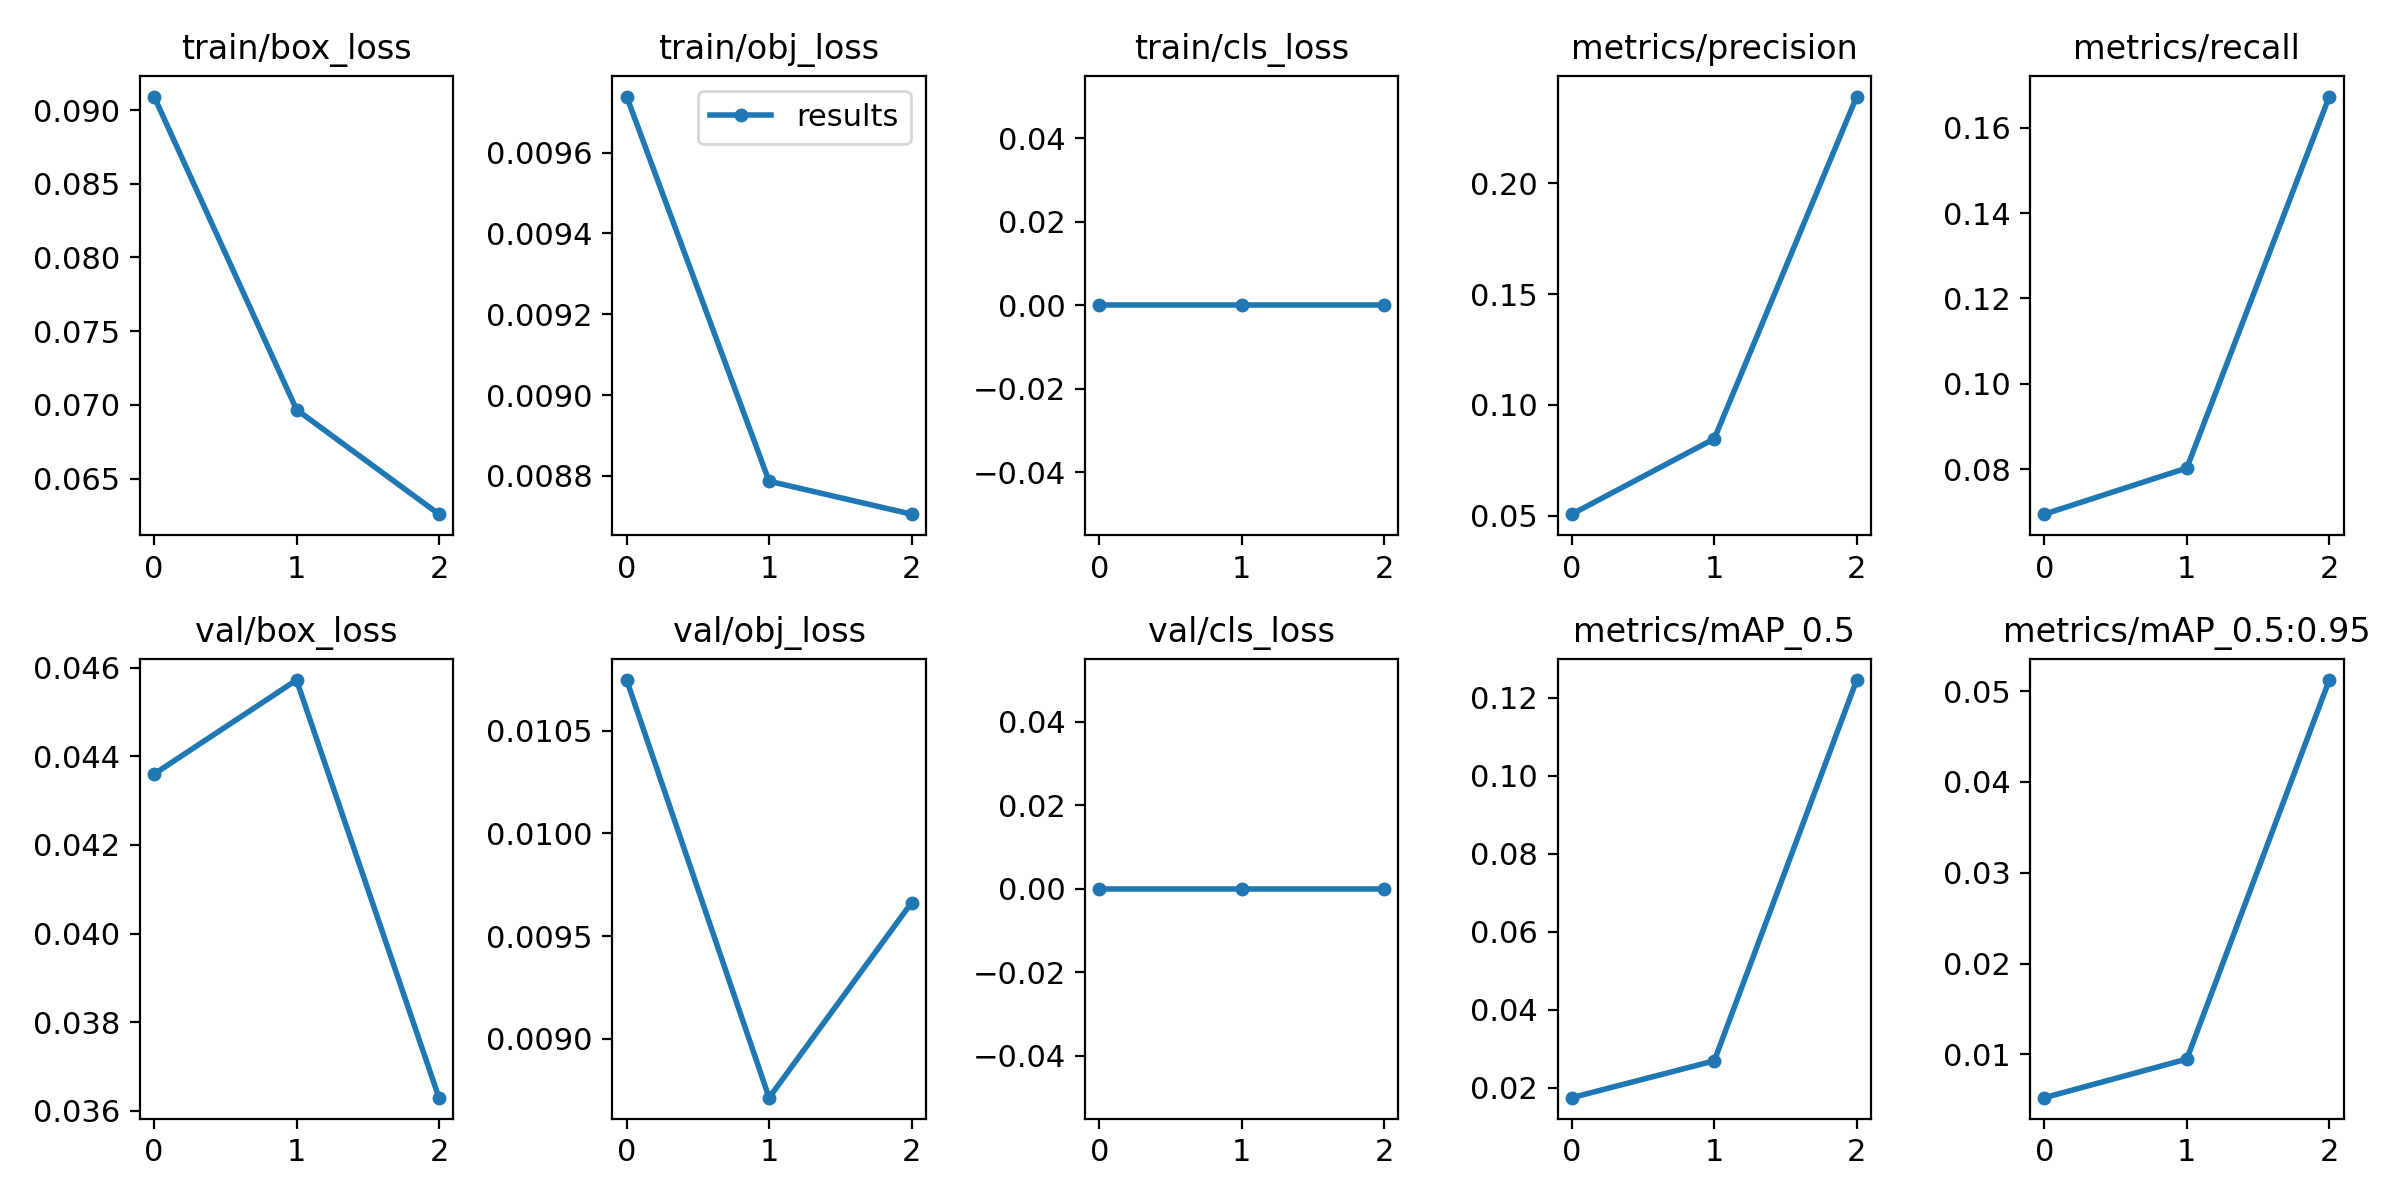

In [16]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.imread('./runs/train/exp2/results.png'))